In [36]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lychee
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MI computation

In [23]:
smp = np.random.choice(2, 10)


def get_entropy_from_freq(freq):
    prob = freq / np.sum(freq)
    return -np.sum(prob * np.log2(prob))


def get_entropy(smp):
    freq = np.bincount(smp)
    return get_entropy_from_freq(freq)


print("Entropy of a random sample of 2 values: ")
print(get_entropy(np.random.choice(2, 10000)))


def get_mi(smptup):
    tup, cnt = np.unique(smptup, axis=0, return_counts=True)
    hxy = get_entropy_from_freq(cnt)
    unique_x = np.unique(tup[:, 0])
    freq_x = [np.sum(cnt[tup[:, 0] == x]) for x in unique_x]
    hx = get_entropy_from_freq(freq_x)
    unique_y = np.unique(tup[:, 1])
    freq_y = [np.sum(cnt[tup[:, 1] == y]) for y in unique_y]
    hy = get_entropy_from_freq(freq_y)
    return hx + hy - hxy


def get_mi_emp(smptup):
    return get_mi(smptup)


def get_mi_miller(smptup):
    mi_emp = get_mi_emp(smptup)
    num_nonzero_x = len(np.unique(smptup[:, 0]))
    num_nonzero_y = len(np.unique(smptup[:, 1]))
    return mi_emp - (num_nonzero_x - 1) * (num_nonzero_y - 1) / (
        2 * len(smptup)
    )


def get_mi_chao(smptup, domain_size, debug=False):
    sample_matrix = np.zeros((domain_size, domain_size))
    for i in range(len(smptup)):
        sample_matrix[smptup[i][0], smptup[i][1]] += 1
    # ChaoSRM: is_flat = False, is_adjust = True, is_muller = True
    return lychee.lychee(sample_matrix, False, True, True, debug)


print("Mutual information of two independent random samples of 2 values: ")
smp1 = np.random.choice(2, 10000)
smp2 = np.random.choice(2, 10000)
smptup = np.vstack((smp1, smp2)).T
print(get_mi(smptup))

Entropy of a random sample of 2 values: 
0.9998890827627154
Mutual information of two independent random samples of 2 values: 
0.00018009783843031535


# Crypto1

In [3]:
state_length = 48
domain_size = 2

In [4]:
def fa(a, b, c, d, m=domain_size):
    # ((a || b) ^ (a && d)) ^ (c && ((a ^ b) || d))
    return ((a or b) ^ (a and d)) ^ (c and ((a ^ b) or d))


def fb(a, b, c, d, m=domain_size):
    # ((a && b) || c) ^ ((a ^ b) && (c || d))
    return ((a and b) or c) ^ ((a ^ b) and (c or d))


def fc(a, b, c, d, e, m=domain_size):
    # (a || ((b || e) && (d ^ e))) ^ ((a ^ (b && d)) && ((c ^ d) || (b && e)))
    return (a or ((b or e) and (d ^ e))) ^ (
        (a ^ (b and d)) and ((c ^ d) or (b and e))
    )

In [5]:
fa1idxs = [9, 11, 13, 15]
fb2idxs = [17, 19, 21, 23]
fb3idxs = [25, 27, 29, 31]
fa4idxs = [33, 35, 37, 39]
fb5idxs = [41, 43, 45, 47]


def get_obs(state):
    return fc(
        fa(*[state[i] for i in fa1idxs]),
        fb(*[state[i] for i in fb2idxs]),
        fb(*[state[i] for i in fb3idxs]),
        fa(*[state[i] for i in fa4idxs]),
        fb(*[state[i] for i in fb5idxs]),
    )

In [6]:
initial_state = np.random.choice(domain_size, state_length)
get_obs(initial_state)

0

In [7]:
target_idx = 5
sample_size = 100
data = []
for _ in range(sample_size):
    sec = np.random.randint(2)
    state = np.copy(initial_state)
    if sec:
        initial_state[target_idx] = int(not initial_state[target_idx])
    obs = get_obs(state)
    data.append((sec, obs))
data = np.array(data)
print(f"MI for {target_idx=}: {get_mi(data)}")

MI for target_idx=5: 0.0


In [8]:
num_state = 10000

raw_data = {idx: [] for idx in range(state_length)}
for iter_idx in range(num_state):
    print(f"{iter_idx=}/{num_state=}", end="\r")
    initial_state = np.random.choice(domain_size, state_length)
    init_obs = get_obs(initial_state)
    for target_idx in range(state_length):
        sec = np.random.randint(domain_size)
        if sec:
            flipped_state = np.copy(initial_state)
            flipped_state[target_idx] += sec
            flipped_state[target_idx] %= domain_size
            flip_obs = get_obs(flipped_state)
            diff = (flip_obs - init_obs) % domain_size
            raw_data[target_idx].append((iter_idx, sec, diff))
        else:
            raw_data[target_idx].append((iter_idx, 0, 0))
for idx in range(state_length):
    raw_data[idx] = np.array(raw_data[idx])
print(raw_data[0].shape)

(10000, 3)999/num_state=10000


In [9]:
for idx in range(state_length):
    raw_data_of_idx = raw_data[idx]
    mi_from_raw_data = get_mi(raw_data_of_idx[:, 1:])
    print(f"{idx=}: {mi_from_raw_data:.2e}")

idx=0: 0.00e+00
idx=1: 0.00e+00
idx=2: 0.00e+00
idx=3: 0.00e+00
idx=4: 0.00e+00
idx=5: 0.00e+00
idx=6: 0.00e+00
idx=7: 0.00e+00
idx=8: 0.00e+00
idx=9: 1.43e-01
idx=10: 0.00e+00
idx=11: 1.42e-01
idx=12: 0.00e+00
idx=13: 2.23e-01
idx=14: 0.00e+00
idx=15: 1.38e-01
idx=16: 0.00e+00
idx=17: 1.58e-01
idx=18: 0.00e+00
idx=19: 1.58e-01
idx=20: 0.00e+00
idx=21: 1.02e-01
idx=22: 0.00e+00
idx=23: 4.47e-02
idx=24: 0.00e+00
idx=25: 1.56e-01
idx=26: 0.00e+00
idx=27: 1.61e-01
idx=28: 0.00e+00
idx=29: 1.01e-01
idx=30: 0.00e+00
idx=31: 4.79e-02
idx=32: 0.00e+00
idx=33: 1.76e-01
idx=34: 0.00e+00
idx=35: 1.80e-01
idx=36: 0.00e+00
idx=37: 2.93e-01
idx=38: 0.00e+00
idx=39: 1.67e-01
idx=40: 0.00e+00
idx=41: 1.55e-01
idx=42: 0.00e+00
idx=43: 1.56e-01
idx=44: 0.00e+00
idx=45: 9.72e-02
idx=46: 0.00e+00
idx=47: 4.82e-02


Text(0, 0.5, 'Mutual Information')

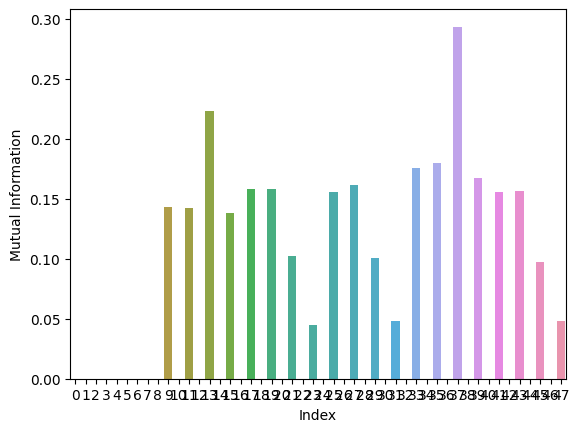

In [10]:
# draw boxplot of mi_data
fig, ax = plt.subplots()
sns.barplot(
    x=[idx for idx in range(state_length)],
    y=[get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)],
    ax=ax,
)
ax.set_xlabel("Index")
ax.set_ylabel("Mutual Information")

# Crypto*

In [61]:
state_length = 24
domain_size = 2 ** 4

In [62]:
# a  or b -> a ** (b + 1)
# a and b -> a * b
# a xor b -> a + b


def anding(a, b, m=domain_size):
    return (a * b) % m


def oring(a, b, m=domain_size):
    return (a ** ((b + 1) % m)) % m


def xoring(a, b, m=domain_size):
    return (a + b) % m


def fa(a, b, c, d, m=domain_size):
    # ((a || b) ^ (a && d)) ^ (c && ((a ^ b) || d))
    return xoring(
        (oring(a, b) ^ anding(a, d)), anding(c, oring(xoring(a, b), d))
    )


def fb(a, b, c, d, m=domain_size):
    # ((a && b) || c) ^ ((a ^ b) && (c || d))
    return xoring((oring(anding(a, b), c)), anding(xoring(a, b), oring(c, d)))


# def fc(a, b, c, d, e, m=domain_size):
#     # (a || ((b || e) && (d ^ e))) ^ ((a ^ (b && d)) && ((c ^ d) || (b && e)))
#     return xoring(
#         (oring(a, anding(oring(b, e), xoring(d, e)))),
#         anding(
#             xoring(a, anding(b, d)),
#             oring(xoring(c, d), anding(b, e)),
#         ),
#     )


def fc(a, b, c, d, e, m=domain_size):
    # a ^ b ^ c ^ d ^ e
    return xoring(xoring(xoring(xoring(a, b), c), d), e)
    # return anding(xoring(xoring(xoring(a, anding(b, 1)), c), oring(d, 3)), e)

In [63]:
fa1idxs = [4, 5, 6, 7]
fb2idxs = [8, 9, 10, 11]
fb3idxs = [12, 13, 14, 15]
fa4idxs = [16, 17, 18, 19]
fb5idxs = [20, 21, 22, 23]


def get_obs(state):
    return fc(
        fa(*[state[i] for i in fa1idxs]),
        fb(*[state[i] for i in fb2idxs]),
        fb(*[state[i] for i in fb3idxs]),
        fa(*[state[i] for i in fa4idxs]),
        fb(*[state[i] for i in fb5idxs]),
    )

Entropy of the output: 3.9992675517035208


<AxesSubplot: ylabel='Count'>

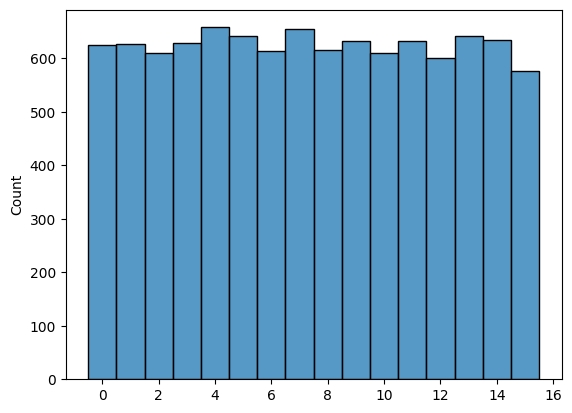

In [64]:
num_state = 10000
data = []
for _ in range(num_state):
    init_state = np.random.choice(domain_size, state_length)
    data.append(get_obs(init_state))
data = np.array(data)
print(f"Entropy of the output: {get_entropy(data)}")

fig, ax = plt.subplots()
sns.histplot(data, discrete=True, ax=ax)

In [65]:
num_state = 10000

raw_data = {idx: [] for idx in range(state_length)}
for iter_idx in range(num_state):
    print(f"{iter_idx=}/{num_state=}", end="\r")
    initial_state = np.random.choice(domain_size, state_length)
    init_obs = get_obs(initial_state)
    for target_idx in range(state_length):
        sec = np.random.randint(domain_size)
        if sec:
            flipped_state = np.copy(initial_state)
            flipped_state[target_idx] += sec
            flipped_state[target_idx] %= domain_size
            flip_obs = get_obs(flipped_state)
            diff = (flip_obs - init_obs) % domain_size
            raw_data[target_idx].append((iter_idx, sec, diff))
        else:
            raw_data[target_idx].append((iter_idx, 0, 0))
for idx in range(state_length):
    raw_data[idx] = np.array(raw_data[idx])
print(raw_data[0].shape)

(10000, 3)999/num_state=10000


In [66]:
for idx in range(state_length):
    raw_data_of_idx = raw_data[idx]
    mi_from_raw_data = get_mi(raw_data_of_idx[:, 1:])
    print(f"{idx=}: {mi_from_raw_data:.2e}")

idx=0: 0.00e+00
idx=1: 0.00e+00
idx=2: 0.00e+00
idx=3: 0.00e+00
idx=4: 6.48e-01
idx=5: 4.42e-01
idx=6: 1.02e+00
idx=7: 5.71e-01
idx=8: 8.45e-01
idx=9: 8.47e-01
idx=10: 4.76e-01
idx=11: 1.36e-01
idx=12: 8.45e-01
idx=13: 8.56e-01
idx=14: 4.84e-01
idx=15: 1.48e-01
idx=16: 6.38e-01
idx=17: 4.43e-01
idx=18: 1.01e+00
idx=19: 5.83e-01
idx=20: 8.60e-01
idx=21: 8.66e-01
idx=22: 4.53e-01
idx=23: 1.44e-01


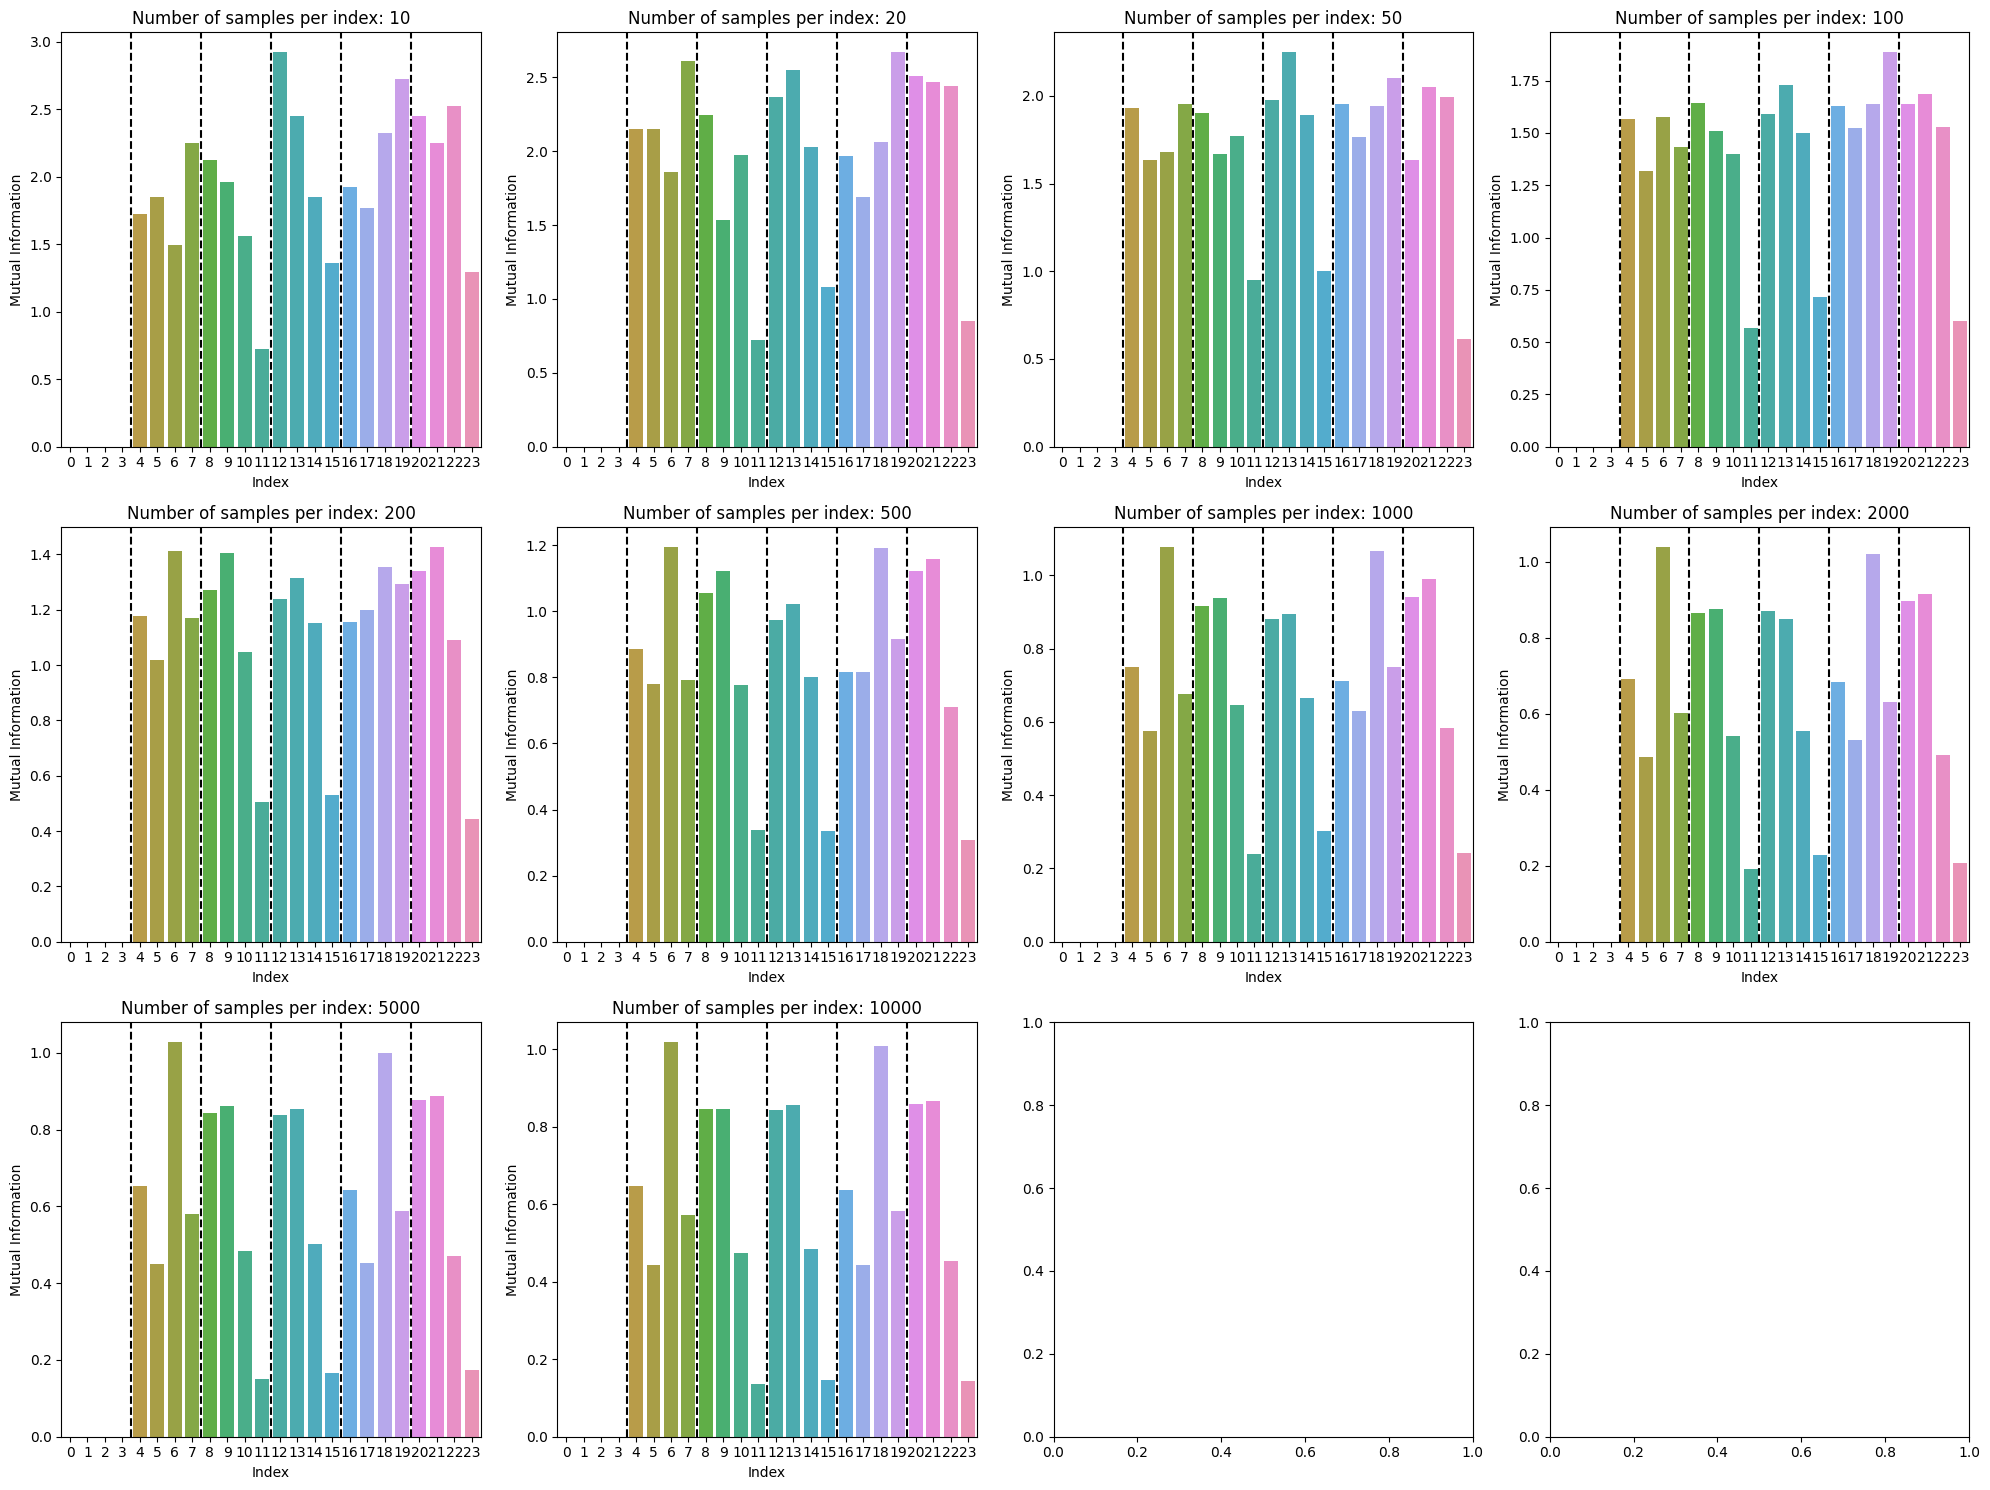

In [67]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_emp(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.tight_layout()
plt.show()

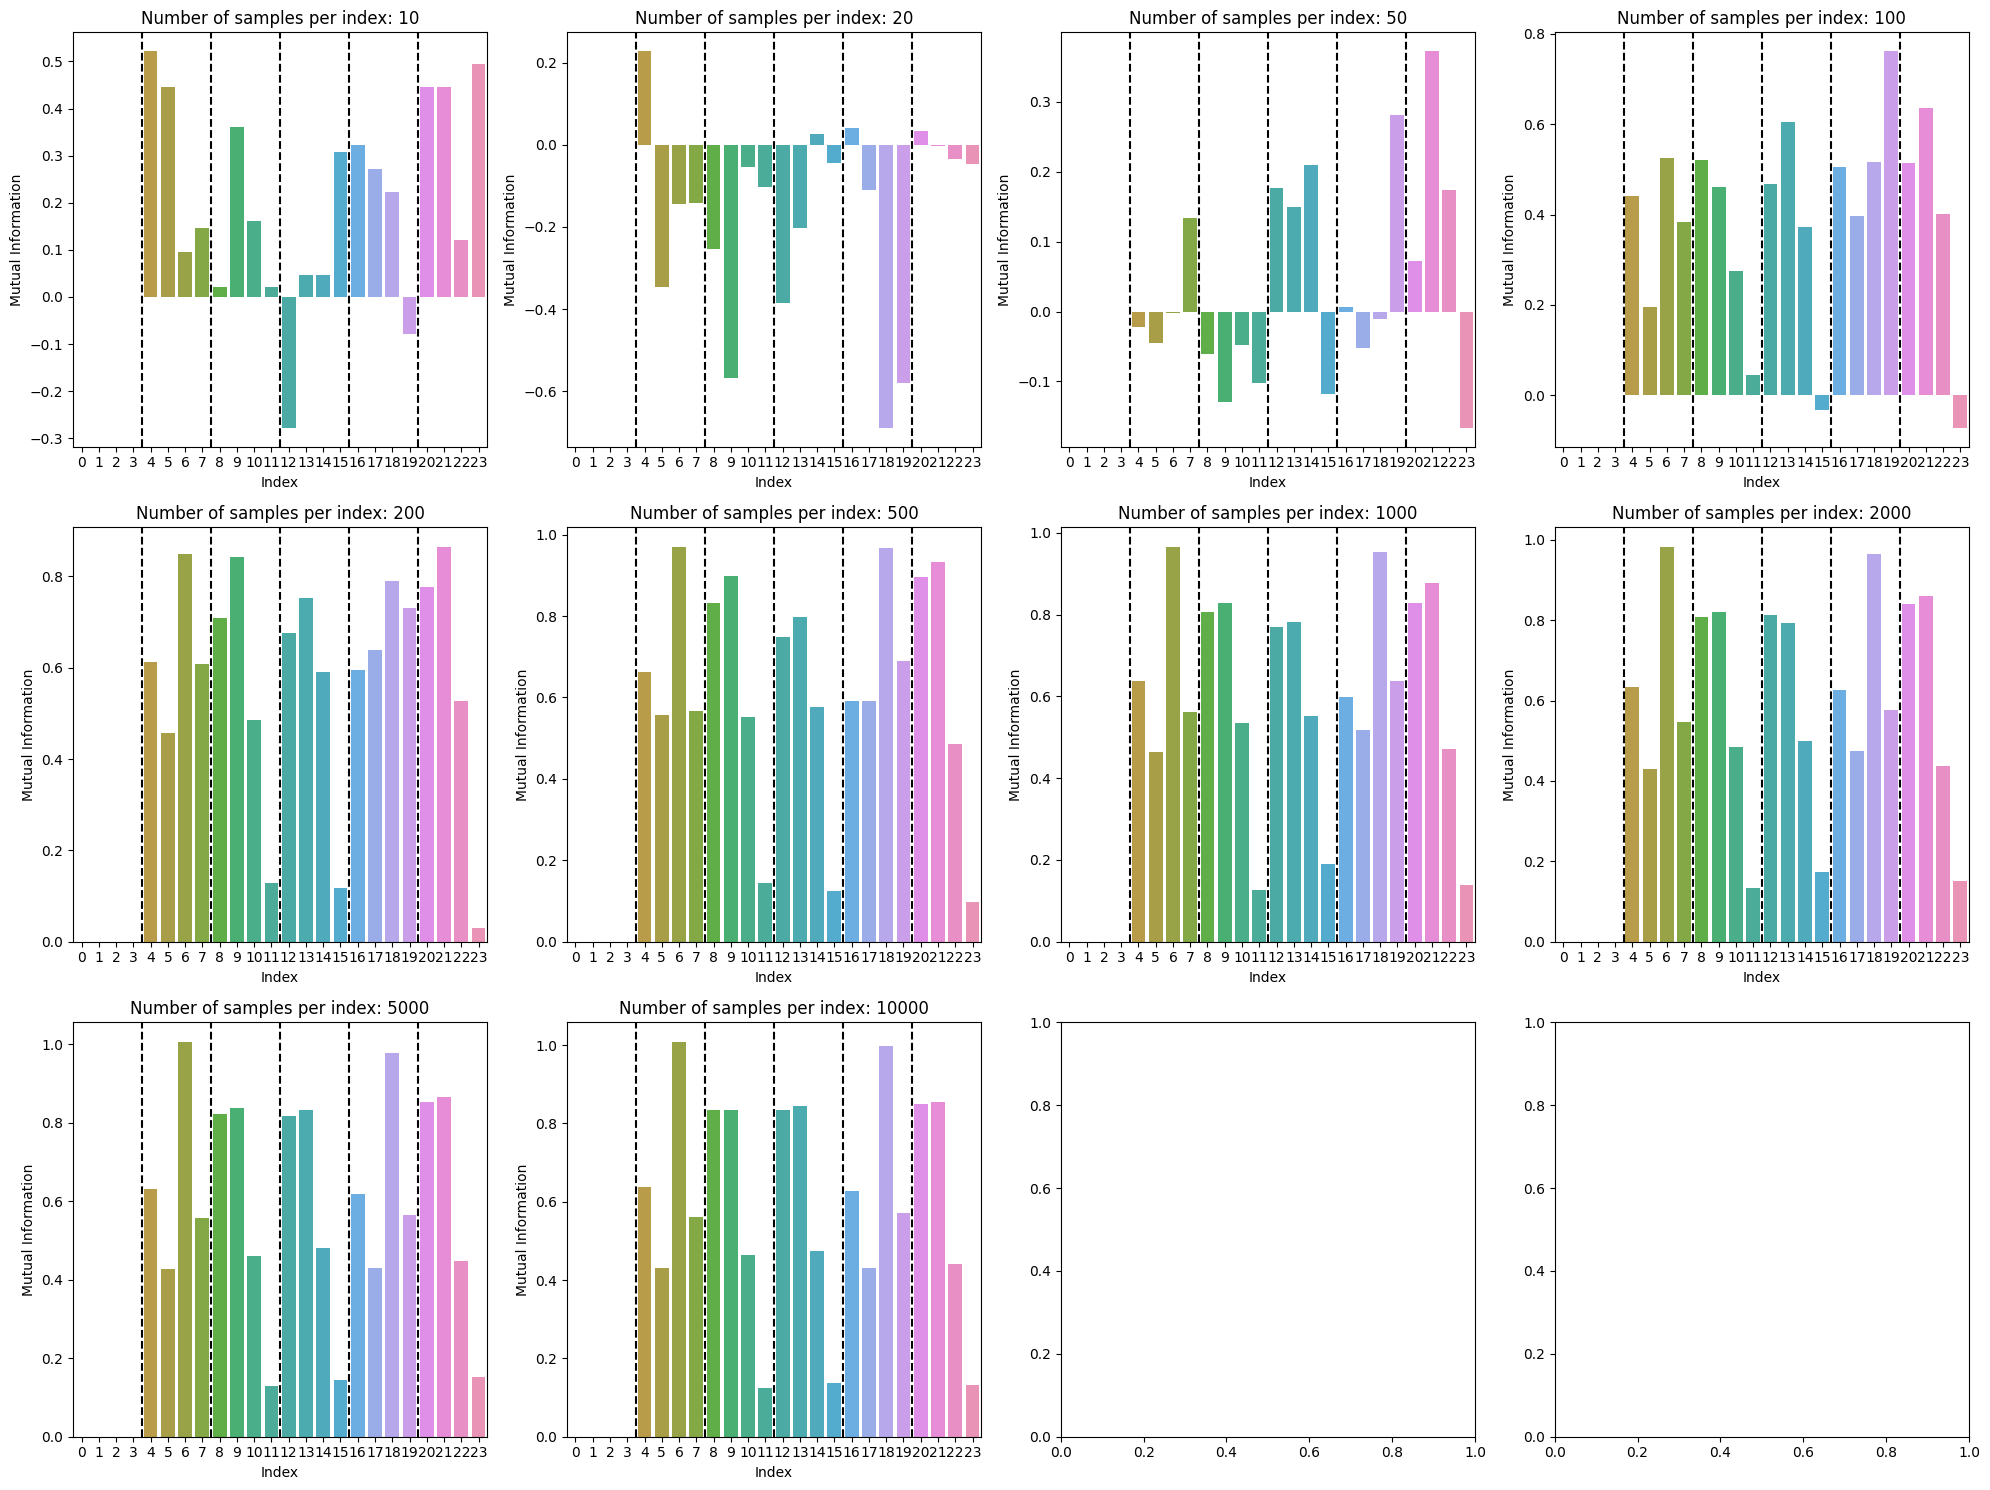

In [68]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_miller(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.tight_layout()
plt.show()

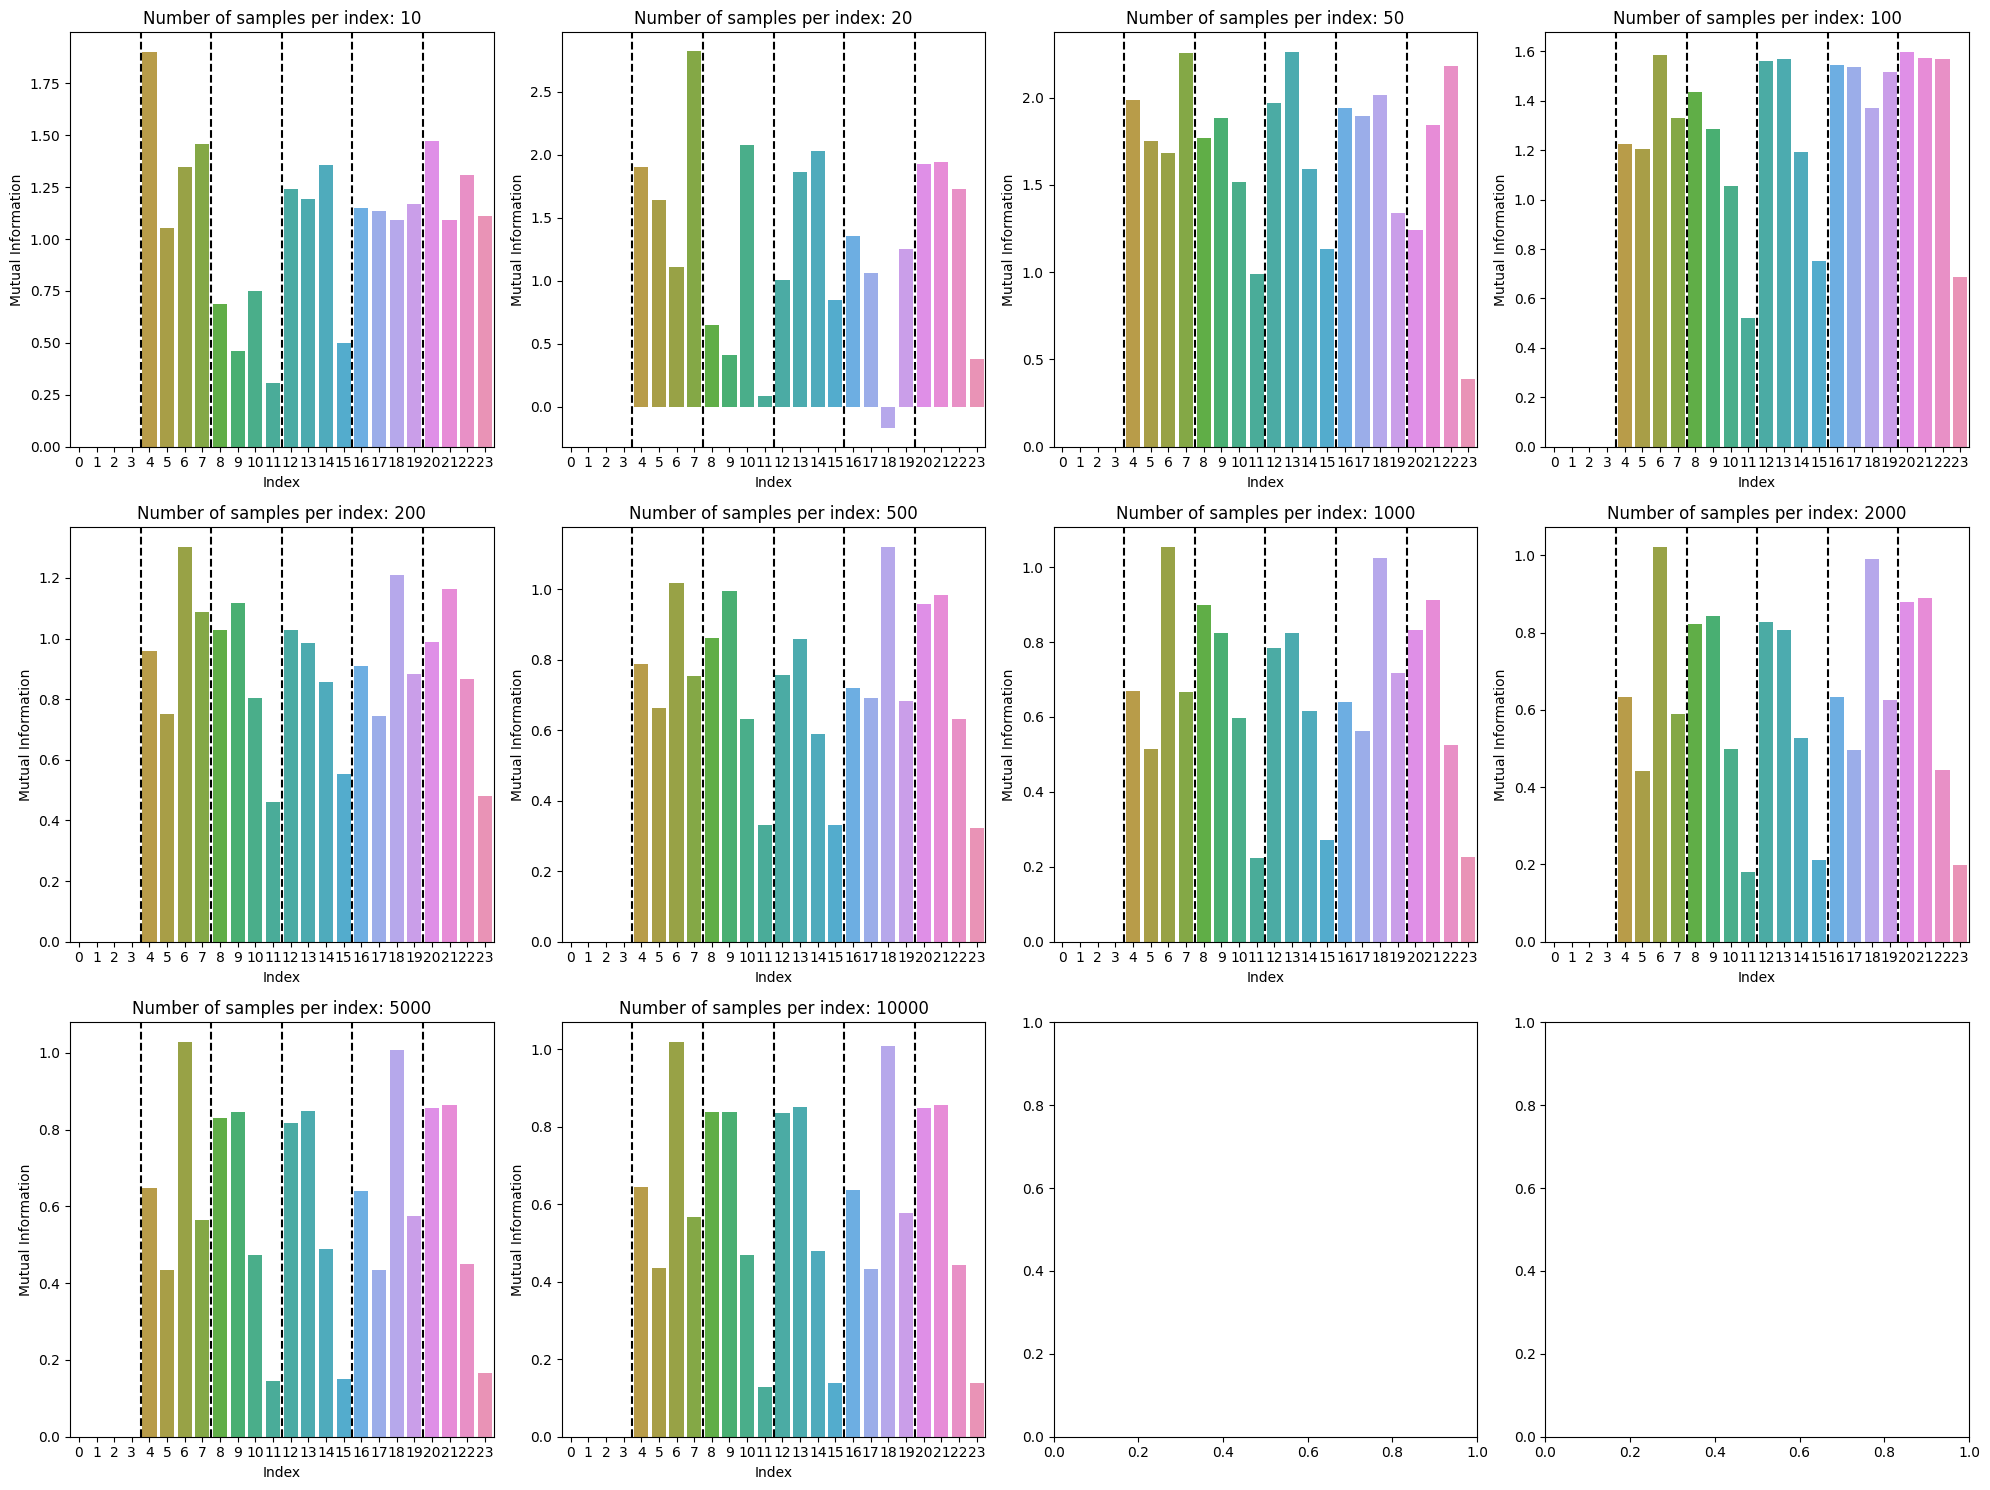

In [69]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_chao(
                raw_data[idx][: int(num_state * prop_ratio), 1:],
                domain_size,
                debug=False,
            )
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.tight_layout()
plt.show()

In [58]:
data = []
mi_gt = np.array(
    [get_mi_emp(raw_data[idx][:, 1:]) for idx in range(state_length)]
)
# print(mi_gt)
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
for prop_ratio in prop_ratios:
    mi_emp = np.array(
        [
            get_mi_emp(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ]
    )
    diff = mi_emp - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("emp", state_length),
                np.arange(state_length),
                mi_emp,
                diff,
            )
        ).T
    )
    mi_miller = np.array(
        [
            get_mi_miller(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ]
    )
    diff = mi_miller - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("miller", state_length),
                np.arange(state_length),
                mi_miller,
                diff,
            )
        ).T
    )
    mi_chao = np.array(
        [
            get_mi_chao(
                raw_data[idx][: int(num_state * prop_ratio), 1:],
                domain_size,
                debug=False,
            )
            for idx in range(state_length)
        ]
    )
    diff = mi_chao - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("chao", state_length),
                np.arange(state_length),
                mi_chao,
                diff,
            )
        ).T
    )
diff_df = np.vstack(data)
diff_df = pd.DataFrame(
    diff_df, columns=["n", "method", "idx", "mi", "diff"]
)
diff_df

,n,method,idx,mi,diff
0,10,emp,0,0.0,0.0
1,10,emp,1,0.0,0.0
2,10,emp,2,0.0,0.0
3,10,emp,3,0.0,0.0
4,10,emp,4,2.0464393446710156,1.4012134095316204
...,...,...,...,...,...
715,10000,chao,19,0.5733718551126613,-0.007501330884780555
716,10000,chao,20,0.850083523373244,0.002444277720440091
717,10000,chao,21,0.8430444029400599,-0.021050989280748666
718,10000,chao,22,0.4557280914263919,-0.012354438265240741


In [60]:
# show min, max, mean, median, MSE
diff_df["n"] = diff_df["n"].astype(int)
# order of method: emp, miller, chao
diff_df["method"] = pd.Categorical(
    diff_df["method"], categories=["emp", "miller", "chao"]
)
diff_df["idx"] = diff_df["idx"].astype(int)
diff_df["mi"] = diff_df["mi"].astype(float)
diff_df["diff"] = diff_df["diff"].astype(float)
diff_df["s.e."] = diff_df["diff"] ** 2
diff_df["noeffect"] = diff_df["mi"] < 0.1
diff_df.groupby(["n", "method"]).agg(
    {"diff": ["mean", "median"], "s.e.": "mean", "noeffect": "sum"}
)

diff                s.e. noeffect
                  mean    median      mean      sum
n     method                                       
10    emp     1.189227  1.404052  1.883599        4
      miller -0.344106 -0.339849  0.243832       11
      chao    0.310701  0.295399  0.229080        4
20    emp     1.251296  1.436538  2.054316        4
      miller -0.624745 -0.691457  0.605633       21
      chao    0.680401  0.737086  0.974317        5
50    emp     1.017609  1.145037  1.302753        4
      miller -0.463641 -0.441369  0.335816       17
      chao    0.958552  1.064169  1.227638        4
100   emp     0.718290  0.809431  0.651208        4
      miller -0.153585 -0.104679  0.053934        6
      chao    0.541941  0.569974  0.384340        4
200   emp     0.421360  0.456530  0.224714        4
      miller -0.023952 -0.004878  0.008995        6
      chao    0.260425  0.285848  0.092147        4
500   emp     0.183817  0.204772  0.044490        4
      miller -0.000558  0.000000  0.003892        4
      chao    0.084955  0.097447  0.012895        4
1000  emp     0.093501  0.115882  0.011969        4
      miller -0.000249  0.003382  0.001478        4
      chao    0.038006  0.019409  0.004498        4
2000  emp     0.046911  0.048792  0.003086        4
      miller  0.000036  0.000000  0.000445        4
      chao    0.015858  0.015701  0.001089        4
5000  emp     0.009028  0.010638  0.000168        4
      miller -0.009722 -0.009935  0.000184        4
      chao   -0.003662 -0.001261  0.000145        4
10000 emp     0.000000  0.000000  0.000000        4
      miller -0.009375 -0.011250  0.000105        4
      chao   -0.007998 -0.008766  0.000095        4

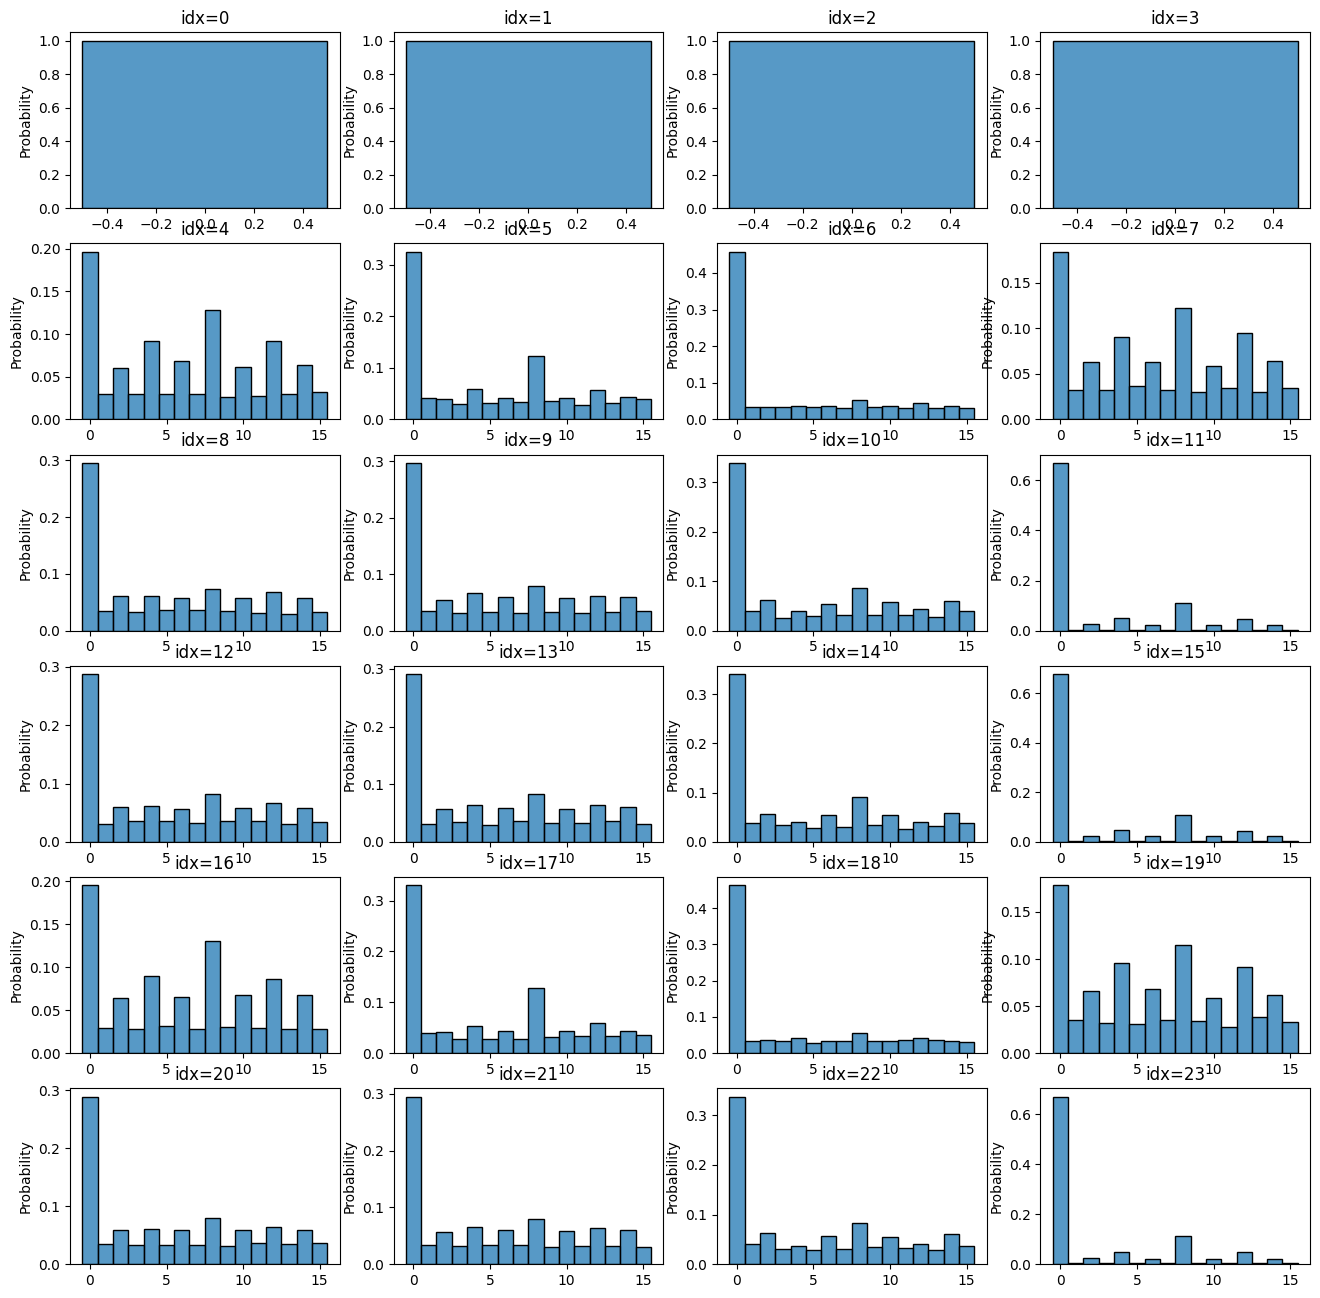

In [19]:
# probability of observables for each secret
fig, axes = plt.subplots(6, 4, figsize=(16, 16))
for idx in range(state_length):
    ax = axes[idx // 4, idx % 4]
    sns.histplot(
        raw_data[idx][:, 2], discrete=True, ax=ax, stat="probability"
    )
    ax.set_title(f"idx={idx}")
plt.show()